### **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **Import Necessary Libraries**

In [2]:
import numpy as np
import os
import sys
import time
import csv
from glob import glob
import cv2    
import pandas as pd
from PIL import Image, ImageFile
from collections import OrderedDict
import matplotlib.pyplot as plt  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from tqdm.notebook import tqdm
from tqdm import tnrange
from collections import OrderedDict
import sys
import itertools
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn

In [3]:
!pip install pytorch_model_summary
from pytorch_model_summary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Files
Train_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images'
Train_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train masks'
Val_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Val images'
Val_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Val masks'
Test_img_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Test images'
Test_seg_folder = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Test masks'

train_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TrainCls.csv'
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TestCls.csv'
val_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/ValCls.csv'

classes=['benign', 'melanoma', 'seborrheic_keratosis']
counts=np.zeros(3).astype(np.int)
train_csv = pd.read_csv(train_csv_path)
melanoma_imgs = train_csv[train_csv['label']==1] #melanoma
seborrheic_imgs = train_csv[train_csv['label']==2] #seborrheic
new_train_csv = train_csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### **Set the device as CUDA or CPU**

In [5]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if use_cuda:
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))
else:
    print('No GPU found. Please use a GPU to train your neural network.')

Default GPU Device: Tesla T4


### **Focal Loss**

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        _, target = torch.max(target, 1)
        target = target.view(-1,1)
        target = target.type(torch.int64)
        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

### **Explore the Data**

There are 3630 total train images.
There are 150 total validation images.
There are 600 total test images.


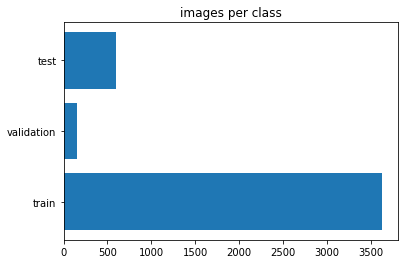

In [7]:
# load filenames for images
train_files = []
valid_files = []
test_files = []
files = ['Train images', 'Val images', 'Test images']
mypath = "/content/drive/MyDrive/Colab Notebooks/ISIC 2017"

for file in files:
    path = os.path.join(mypath, file, "*.jpg")

    if file == 'Train images':
        train_files.extend(glob(path))
    elif file == 'Val images':
        valid_files.extend(glob(path))
    else:
        test_files.extend(glob(path))
            
# print number of images in each dataset
print('There are %d total train images.' % len(train_files))
print('There are %d total validation images.' % len(valid_files))
print('There are %d total test images.' % len(test_files))

plt.barh(['train', 'validation', 'test'], [len(train_files), len(valid_files), len(test_files)])
plt.title('images per class')
plt.show()

### **Display a few Examples**

/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/imageflipV1771.jpg 	img shape: (2848, 4288, 3) 	min/max: [16 10  7] [255 255 255]
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/imageflipH1771.jpg 	img shape: (2848, 4288, 3) 	min/max: [15 10  7] [255 255 255]
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/imageflipV1774.jpg 	img shape: (2848, 4288, 3) 	min/max: [35 31 32] [255 255 255]


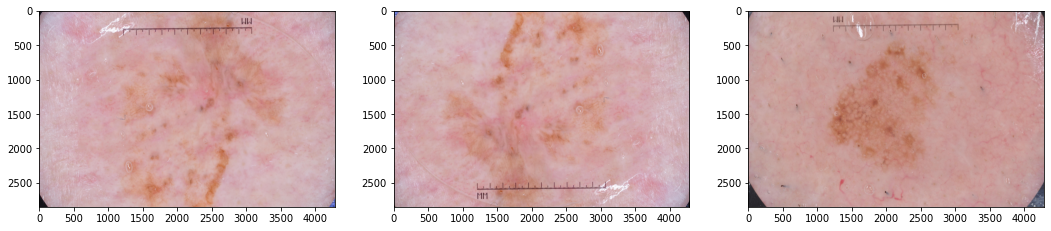

In [8]:
plt.figure(figsize=(18,9))
for index, img_path in enumerate(train_files[:3]):
    plt.subplot(1,3, index+1)
    # images are within [0,255] and must be scaled to [0,1] for pytorch pretrained models
    img = cv2.imread(img_path)
    print(img_path, '\timg shape:', img.shape, '\tmin/max:', img.min(axis=(0,1)), img.max(axis=(0,1)))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
plt.show()

train set: number of  benign  images:  1372
train set: number of  melanoma  images:  374
train set: number of  seborrheic_keratosis  images:  254


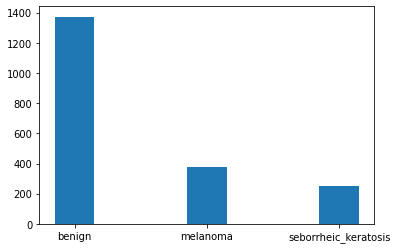

In [9]:
for index, label in enumerate(classes):
    label_path = pd.read_csv(train_csv_path)
    counts[index] = len(label_path[label_path['label']==index])
    print('train set: number of ',label,' images: ',counts[index])

plt.bar(classes, counts, width = 0.3)
plt.ylim(bottom=0)
plt.show()

### **Data augmentation to balance under-represented classes**

### **Run Only Once**

In [ ]:
counth = 0
countv = 0

for idx, row in melanoma_imgs.iterrows():
    
    img_id =f'/' + row['image_id']
    img_path = Train_img_folder + img_id + '.jpg'
    # print(img_path)
    image = Image.open(img_path)

    # # Rotae 45 degree 
    # rotate_45 = image.rotate(45)
    # rotate_45.save(os.path.join(Train_img_folder,'m_imageRot45_{}.jpg'.format(idx)), 'JPEG')
    # new_row_rot = {'image_id':'m_imageRot45_{}'.format(idx), 'melanoma':1, 'seborrheic_keratosis': 0, 'label':1}
    # new_train_csv = new_train_csv.append(new_row_rot, ignore_index=True)
    
    # flip up-down using np.flipud
    up_down = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    up_down.save(os.path.join(Train_img_folder,'imageflipV{}.jpg'.format(idx)), 'JPEG')
    countv+=1
    new_row_1 = {'image_id':'m_imageflipV{}'.format(idx), 'melanoma':1, 'seborrheic_keratosis': 0, 'label':1}
    new_train_csv = new_train_csv.append(new_row_1, ignore_index=True)
    
    # flip up-down using np.flipud
    left_right = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    left_right.save(os.path.join(Train_img_folder,'imageflipH{}.jpg'.format(idx)), 'JPEG')
    counth+=1
    new_row_2 = {'image_id':'m_imageflipH{}'.format(idx), 'melanoma':1, 'seborrheic_keratosis': 0, 'label':1}
    new_train_csv = new_train_csv.append(new_row_2, ignore_index=True)

#print('Images generated and saved to disk: {} Horizontal flip, {} vertical flip...{} images in total'.format(counth, countv, counth+countv))

In [ ]:
counth = 0
countv = 0
for idx, row in seborrheic_imgs.iterrows():
    
    img_id =f'/' + row['image_id']
    img_path = Train_img_folder + img_id + '.jpg'
    # print(img_path)
    image = Image.open(img_path)
    
    # flip up-down using np.flipud
    up_down = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    up_down.save(os.path.join(Train_img_folder,'imageflipV{}.jpg'.format(idx)), 'JPEG')
    countv+=1
    new_row_1 = {'image_id':'s_imageflipV{}'.format(idx), 'melanoma':0, 'seborrheic_keratosis': 1, 'label':2}
    new_train_csv = new_train_csv.append(new_row_1, ignore_index=True)
    
    # flip up-down using np.flipud
    left_right = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    left_right.save(os.path.join(Train_img_folder,'imageflipH{}.jpg'.format(idx)), 'JPEG')
    counth+=1
    new_row_2 = {'image_id':'s_imageflipH{}'.format(idx), 'melanoma':0, 'seborrheic_keratosis': 1, 'label':2}
    new_train_csv = new_train_csv.append(new_row_2, ignore_index=True)

In [ ]:
new_train_csv.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ISIC 2017/new_train_Cls.csv', sep='\t', encoding='utf-8', header='true')


### **Data Loader Class**

In [10]:
w_aug_train_csv_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/v2_train_Cls.csv'

train set: number of  benign  images:  1372
train set: number of  melanoma  images:  1122
train set: number of  seborrheic_keratosis  images:  762


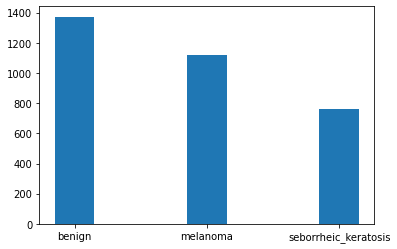

In [11]:
for index, label in enumerate(classes):
    label_path = pd.read_csv(w_aug_train_csv_path)
    counts[index] = len(label_path[label_path['label']==index])
    print('train set: number of ',label,' images: ',counts[index])

plt.bar(classes, counts, width = 0.3)
plt.ylim(bottom=0)
plt.show()

In [12]:
# Let's calculate corrective weights to apply during training
# Calculate corrective weights for class imbalance
counts = counts.astype(np.float64)
median_freq=np.median(counts)
class_weights=np.zeros_like(classes, dtype=np.float64)
print('Corrective weights to account for dataset over-representation of Nevus')
for index, label in enumerate(classes):
    class_weights[index]=median_freq / counts[index]
    print(label,' : ',class_weights[index])

class_weights = torch.FloatTensor(class_weights)
if use_cuda:
    class_weights = class_weights.cuda()

Corrective weights to account for dataset over-representation of Nevus
benign  :  0.8177842565597667
melanoma  :  1.0
seborrheic_keratosis  :  1.4724409448818898


In [13]:
class_weights_tensor =  class_weights.clone().detach().cuda()
class_weights_tensor

tensor([0.8178, 1.0000, 1.4724], device='cuda:0')

In [14]:
# Data Loader Class

class SkinLesionDataset(Dataset):

    def __init__(self, csv_file, image_folder, img_transform=None):
        
        self.path_df = pd.read_csv(csv_file)
        self.image_folder = image_folder  
        self.img_transform = img_transform     
        self.images = []
        self.labels = []

        for idx, row in self.path_df.iterrows():
            
            label = []
            img_id =f'/' + row['image_id']
            melanoma_bit = row['melanoma']
            seborrheic_keratosis_bit = row['seborrheic_keratosis']
            if(melanoma_bit==0 and seborrheic_keratosis_bit==0):
              benign_bit = 1
            else:
              benign_bit = 0
            label.append(melanoma_bit)
            label.append(benign_bit)
            label.append(seborrheic_keratosis_bit)

            img_path = image_folder + img_id + '.jpg'
            print(img_path)

            image = Image.open(img_path).convert("RGB")

            if self.img_transform:
              image = self.img_transform(image)

            self.images.append(image)
            self.labels.append(label)

        
    def __len__(self):
        return len(self.images) # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = torch.FloatTensor(self.labels[idx])
        return image, label

In [15]:
def get_loaders (input_shape, batch_size_train, batch_size_val, batch_size_test, num_workers):
    
    (img_dim_H,img_dim_W) = input_shape

    img_transforms = transforms.Compose([transforms.Resize((img_dim_H,img_dim_W)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225]) # Imagenet standards
    ])

    #Dataset
    isic_train = SkinLesionDataset(csv_file=w_aug_train_csv_path,
                                image_folder= Train_img_folder, 
                                img_transform = img_transforms)


    isic_val = SkinLesionDataset(csv_file=val_csv_path, 
                                image_folder= Val_img_folder, 
                                img_transform = img_transforms)

    isic_test = SkinLesionDataset(csv_file=test_csv_path, 
                                image_folder= Test_img_folder, 
                                img_transform = img_transforms)
    
    # Dataloaders
    train_loader = torch.utils.data.DataLoader(isic_train, batch_size=batch_size_train, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(isic_test, batch_size=batch_size_test, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(isic_val, batch_size=batch_size_val, num_workers=num_workers, pin_memory=True)

    return {'train': train_loader, 'valid': val_loader, 'test': test_loader}

### **Train and Validate the Model**

In [16]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, file_name):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    running_train_loss = []
    running_val_loss = []
    start_time = time.time()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        av_loss_train = 0
        av_loss_val = 0
        
        previous_time = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()

           
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()
            
            ## record the average training loss
            #train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            train_loss += loss.item() * len(target)
            av_loss_train = train_loss / ((batch_idx+1) * batch_size_train)
            
            # Get training statistics.
            current_time = time.time()
            stats = 'Epoch [%d/%d] Step [%d/%d]\t Loss: %.4f\t avg_Loss: %.4f\t' % (epoch, n_epochs, batch_idx+1, len(loaders['train']), loss.item(), av_loss_train)
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics (on different line).
            if (batch_idx+1) % print_every == 0:
                print('\r' + stats)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        dataset_size = 0
        running_corrects = 0
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                #valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                valid_loss += loss.item() * target.size(0)
                av_loss_val = valid_loss / ((batch_idx+1) * batch_size_val)
            
                _, preds = torch.max(output, 1)
                _, actuals = torch.max(target, 1)
                running_corrects += torch.sum(preds == actuals)
                dataset_size += len(data)
        
        accuracy = torch.true_divide(running_corrects, dataset_size) * 100
        #batch_loss = train_loss / len(loaders['train'].dataset)
        # Get training/validation statistics        
        stats = '\nEpoch [%d/%d]\t avg_train Loss: %.4f\t\t\t avg_validation Loss: %.4f\t val_accuracy: %.2f' % (epoch, n_epochs, av_loss_train, av_loss_val, accuracy)   # valid_loss,
            
        # Print validation statistics (on new line).
        print(stats)
        sys.stdout.flush()
        
        # store losses for later use
        running_train_loss.append(av_loss_train)  #train_loss
        running_val_loss.append(av_loss_val)    #valid_loss
        
        ## Save the model if validation loss has decreased
        if av_loss_val < valid_loss_min:
            valid_loss_min = av_loss_val
            save_file = os.path.join(save_path, file_name)
            torch.save(model.state_dict(), save_file)
            # print('improved model saved to disk')
        
        
        #if valid_loss < valid_loss_min:
        #    valid_loss_min = valid_loss
            
        
        scheduler.step(valid_loss)
            
    # return trained model
    return model, running_train_loss, running_val_loss

In [17]:
### Calculate the accuracy
def test(loaders, model, criterion, use_cuda):
    labels = ['melanoma', 'benign', 'seborrheic_keratosis']
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    model.eval()
    
    for batch_idx, (data, targets) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, targets = data.cuda(), targets.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, targets).item()
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss - test_loss))
        
        # convert output probabilities to predicted class
        output = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(output, dim=1)
        _, actuals = torch.max(targets, dim=1)

        
        # compare predictions to true label
        correct_tensor = preds.eq(actuals.view_as(preds))    # equivalent to tensor.view(preds.size())
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        
        # calculate test accuracy for each object class
        for i in range(batch_size_test):
            label = actuals[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    for i in range(num_classes):
        if class_total[i] > 0:
            
            print('Test Accuracy of {}:'.format(labels[i]),
              ' {:.0f}%'.format(100 * class_correct[i] / class_total[i]).ljust(8,' '), 
              '({:.0f}/{:.0f})'.format(np.sum(class_correct[i]), np.sum(class_total[i])))
            
        else:
            print('Test Accuracy of {}: N/A (no training examples)'.format(labels[i]))
                      
    print('\nTest Accuracy (Overall):\t {:.0f}%'.format(100. * np.sum(class_correct) / np.sum(class_total)).expandtabs(71),
      '\t({:.0f}/{:.0f})'.format(np.sum(class_correct), np.sum(class_total)).expandtabs(4))

In [18]:
def plot_loss(model, train_loss, val_loss):
    plt.plot(np.arange(1, n_epochs+1,1), train_loss, label='average train loss')
    plt.plot(np.arange(1, n_epochs+1,1), val_loss, label='average validation loss')
    plt.xlabel('epochs')
    plt.ylabel('running losses')
    plt.title('loss reduction ' + model)
    plt.legend(loc='upper right')
    filename = 'loss_reduction_profile_'+model+'.png'
    plt.savefig(filename)
    plt.show()

### **Get Predictions and Prepare the Result Files**

In [19]:
def test_transform_img(img, input_img_dim):
    test_transform = transforms.Compose([transforms.Resize((input_img_dim[0],input_img_dim[1])),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))
                                        ])
    return test_transform(img)

def get_image(img_path, input_img_dim):
    image = Image.open(img_path)
    image = test_transform_img(image, input_img_dim)
    image = image.requires_grad_(True)
    #image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)                         # add batch dimension
    return image

In [20]:
def get_predictions(model, path_to_files, input_img_dim=(224,224)):
    if use_cuda:
        model = model.cuda()
    model.eval()
    score_1 = []
    score_2 = []
    score_3 = []
    for img_path in tqdm(path_to_files):
        img = get_image(img_path, input_img_dim)
        if use_cuda:
            img = img.cuda()
        pred = model(img).cpu().detach().numpy()
        # pred = np.zeros_like(out)
        # pred[out==np.max(out)] = 1
        score_1.append(float(pred[0][0]))
        score_2.append(float(pred[0][1]))
        score_3.append(float(pred[0][2]))
    return score_1, score_2, score_3 

In [21]:
save_path = "/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models"
def get_scores(model, input_img_dim, filename):
    
    print("\ngetting predictions on all test images:")
    score_1, score_2, score_3 = get_predictions(model, test_files, input_img_dim)

    print("writing score csv file")
    path = os.path.join(save_path, filename) 
    with open(path, 'w', newline='') as csvfile:
        doc = csv.writer(csvfile)
        doc.writerow(['Id', 'melanoma', 'benign', 'seborrheic_keratosis'])
        for i in range(len(test_files)):
            doc.writerow([test_files[i], score_1[i], score_2[i], score_3[i]])

In [22]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue', 'red']
    classes = ['melanoma', 'benign', 'seborrheic_keratosis']

    for i in range(3):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        fpr[i] = fpr[i]
        tpr[i] = tpr[i]
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for {d} (area = {f:.2f})'.format(d=classes[i], f=roc_auc[i]))
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=classes[i], f=roc_auc[i]))

In [23]:
def plot_scores(filename):
    
    # get ground truth labels for test dataset
    truth = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/TestCls.csv')
    y_true = truth[["melanoma", "benign",  "seborrheic_keratosis"]].values
    
    path = os.path.join(save_path, filename) 
    # get model predictions for test dataset
    y_pred = pd.read_csv(path)
    y_pred = y_pred[["melanoma", "benign", "seborrheic_keratosis"]].values
    y_pred = y_pred.astype(float)
    y_true = y_true.astype(float)

    plot_roc_auc(y_true, y_pred)
    

### **Load Data**

In [24]:
image_size = (224, 224)
num_workers = 2
batch_size_train = 10
batch_size_val = 10
batch_size_test = 10
loaders=get_loaders(image_size, batch_size_train, batch_size_val, batch_size_test, num_workers)

/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000000.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000001.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000002.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000003.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000004.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000006.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000007.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000008.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000009.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000010.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000011.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Train images/ISIC_0000012.jpg
/content/drive/MyDrive/Colab Notebooks/ISIC 2017/Tra

# **Model Architecture (VGG-16 with CE)**

## **VGG-16, ADAM, Cross-Entropy**

In [25]:
num_classes = 3

## Specify model architecture 
model_VGG = models.vgg16(pretrained=True)

for param in model_VGG.features.parameters():                     # freeze feature parameters of pre-trained VGG16 model
    param.requires_grad = False

model_VGG.classifier[6] = nn.Linear(4096, num_classes)   # replace last layer with proper output dimensions

# Print summary and move to GPU/CPU
if use_cuda:
    model_VGG = model_VGG.cuda()
    summary(model_VGG, torch.zeros((1, 3, 224, 224)).to(device), show_input=False, show_hierarchical=False, print_summary=True)
else:
    summary(model_VGG, torch.zeros((1, 3, 224, 224)), show_input=False, show_hierarchical=False, print_summary=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

-------------------------------------------------------------------------------
           Layer (type)           Output Shape         Param #     Tr. Param #
               Conv2d-1      [1, 64, 224, 224]           1,792               0
                 ReLU-2      [1, 64, 224, 224]               0               0
               Conv2d-3      [1, 64, 224, 224]          36,928               0
                 ReLU-4      [1, 64, 224, 224]               0               0
            MaxPool2d-5      [1, 64, 112, 112]               0               0
               Conv2d-6     [1, 128, 112, 112]          73,856               0
                 ReLU-7     [1, 128, 112, 112]               0               0
               Conv2d-8     [1, 128, 112, 112]         147,584               0
                 ReLU-9     [1, 128, 112, 112]               0               0
           MaxPool2d-10       [1, 128, 56, 56]               0               0
              Conv2d-11       [1, 256, 56, 56]     

**Specify Loss Function and Optimizer**

In [26]:
criterion = nn.CrossEntropyLoss()     # In Pytorch, CrossEntropyLoss combines a Logsoftmax with a NLLLoss
optimizer = optim.Adam(model_VGG.classifier.parameters(), lr=0.00001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

### **Start Training (VGG16, ADAM, Cross-Entropy)**

In [27]:
# train the model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'

model_VGG, train_loss, val_loss = train(n_epochs, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG_Adam_CE.pt')

Epoch [1/15] Step [100/326]	 Loss: 1.0988	 avg_Loss: 1.0346	
Epoch [1/15] Step [200/326]	 Loss: 1.0686	 avg_Loss: 0.9755	
Epoch [1/15] Step [300/326]	 Loss: 0.7510	 avg_Loss: 0.9329	
Epoch [1/15] Step [326/326]	 Loss: 0.7769	 avg_Loss: 0.9241	
Epoch [1/15]	 avg_train Loss: 0.9241			 avg_validation Loss: 0.7568	 val_accuracy: 70.00
Epoch [2/15] Step [100/326]	 Loss: 0.9341	 avg_Loss: 0.7466	
Epoch [2/15] Step [200/326]	 Loss: 0.9370	 avg_Loss: 0.7230	
Epoch [2/15] Step [300/326]	 Loss: 0.8049	 avg_Loss: 0.7117	
Epoch [2/15] Step [326/326]	 Loss: 0.6099	 avg_Loss: 0.7011	
Epoch [2/15]	 avg_train Loss: 0.7011			 avg_validation Loss: 0.6789	 val_accuracy: 68.00
Epoch [3/15] Step [100/326]	 Loss: 0.2735	 avg_Loss: 0.5770	
Epoch [3/15] Step [200/326]	 Loss: 0.3840	 avg_Loss: 0.5655	
Epoch [3/15] Step [300/326]	 Loss: 0.5873	 avg_Loss: 0.5625	
Epoch [3/15] Step [326/326]	 Loss: 0.7947	 avg_Loss: 0.5596	
Epoch [3/15]	 avg_train Loss: 0.5596			 avg_validation Loss: 0.6334	 val_accuracy: 72.00
E

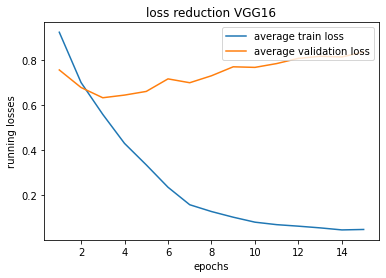

In [28]:
# Display loss reduction profile
plot_loss('VGG16', train_loss, val_loss)

### **Test the Model (VGG-16, ADAM, Cross-Entropy)**

In [29]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_Adam_CE.pt'))
else:
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_Adam_CE.pt', map_location=torch.device('cpu')))

In [30]:
with torch.no_grad():
    test(loaders, model_VGG, criterion, use_cuda)
    get_scores(model_VGG, (224,224), "results_vgg_CE_Adam.csv")

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.799642

Test Accuracy of melanoma:  41%     (48/117)
Test Accuracy of benign:  65%     (255/393)
Test Accuracy of seborrheic_keratosis:  66%     (59/90)

Test Accuracy (Overall):                                                60%     (362/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


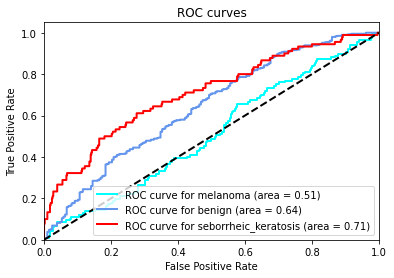

Category melanoma Score: 0.509
Category benign Score: 0.642
Category seborrheic_keratosis Score: 0.709


In [31]:
plot_scores("results_vgg_CE_Adam.csv")

## **VGG-16, SGD, Cross-Entropy**

**Specify Loss Function and Optimizer**

In [32]:
criterion = nn.CrossEntropyLoss()     # In Pytorch, CrossEntropyLoss combines a Logsoftmax with a NLLLoss
optimizer = optim.SGD(model_VGG.classifier.parameters(), lr=0.00001, weight_decay=1e-6, momentum = 0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

### **Start Training (VGG16, ADAM, Cross-Entropy)**

In [33]:
# train the model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'

model_VGG, train_loss, val_loss = train(n_epochs, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG_SGD_CE.pt')

Epoch [1/15] Step [100/326]	 Loss: 0.2192	 avg_Loss: 0.4466	
Epoch [1/15] Step [200/326]	 Loss: 0.4155	 avg_Loss: 0.4371	
Epoch [1/15] Step [300/326]	 Loss: 0.3917	 avg_Loss: 0.4431	
Epoch [1/15] Step [326/326]	 Loss: 0.2469	 avg_Loss: 0.4420	
Epoch [1/15]	 avg_train Loss: 0.4420			 avg_validation Loss: 0.6376	 val_accuracy: 70.00
Epoch [2/15] Step [100/326]	 Loss: 0.2265	 avg_Loss: 0.4153	
Epoch [2/15] Step [200/326]	 Loss: 0.5546	 avg_Loss: 0.4283	
Epoch [2/15] Step [300/326]	 Loss: 0.3142	 avg_Loss: 0.4254	
Epoch [2/15] Step [326/326]	 Loss: 0.6951	 avg_Loss: 0.4300	
Epoch [2/15]	 avg_train Loss: 0.4300			 avg_validation Loss: 0.6368	 val_accuracy: 71.33
Epoch [3/15] Step [100/326]	 Loss: 0.1642	 avg_Loss: 0.4065	
Epoch [3/15] Step [200/326]	 Loss: 0.2880	 avg_Loss: 0.4167	
Epoch [3/15] Step [300/326]	 Loss: 0.1314	 avg_Loss: 0.4311	
Epoch [3/15] Step [326/326]	 Loss: 0.1183	 avg_Loss: 0.4262	
Epoch [3/15]	 avg_train Loss: 0.4262			 avg_validation Loss: 0.6381	 val_accuracy: 71.33
E

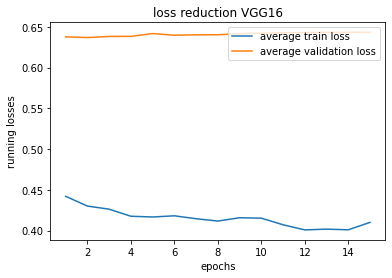

In [34]:
# Display loss reduction profile
plot_loss('VGG16', train_loss, val_loss)

### **Test the Model (VGG-16, SGD, Cross-Entropy)**

In [35]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_SGD_CE.pt'))
else:
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_SGD_CE.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.822614

Test Accuracy of melanoma:  42%     (49/117)
Test Accuracy of benign:  64%     (250/393)
Test Accuracy of seborrheic_keratosis:  68%     (61/90)

Test Accuracy (Overall):                                                60%     (360/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


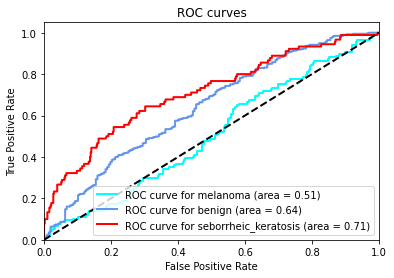

Category melanoma Score: 0.506
Category benign Score: 0.639
Category seborrheic_keratosis Score: 0.711


In [36]:
with torch.no_grad():
    test(loaders, model_VGG, criterion, use_cuda)
    get_scores(model_VGG, (224,224), "results_vgg_CE_SGD.csv")
plot_scores("results_vgg_CE_SGD.csv")

# **Model Architecture (ResNet50 with CE)**

## **ResNet50, ADAM, Cross-Entropy**

In [37]:
model_Resnet50= models.resnet50(pretrained = True)

for param in model_Resnet50.parameters():
    param.requires_grad = True
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('Elu', nn.ELU()),
                          ('Dropout',nn.Dropout(0.05)),
                          ('fc2', nn.Linear(1024, 3)),
                          ]))

model_Resnet50.fc = classifier

if use_cuda:
    model_Resnet50 = model_Resnet50.cuda()

print(summary(model_Resnet50.to(device), torch.zeros((1, 3, 224, 224)).to(device), show_input=False, show_hierarchical=False, print_summary=False))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 112, 112]           9,408           9,408
          BatchNorm2d-2     [1, 64, 112, 112]             128             128
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4       [1, 64, 56, 56]               0               0
           Bottleneck-5      [1, 256, 56, 56]          75,008          75,008
           Bottleneck-6      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-7      [1, 256, 56, 56]          70,400          70,400
           Bottleneck-8      [1, 512, 28, 28]         379,392         379,392
           Bottleneck-9      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-10      [1, 512, 28, 28]         280,064         280,064
          Bottleneck-11      [1, 512, 28, 28]         280,064  

**Specify Loss Function and Optimizer**

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### **Start Training (ResNet50)**

In [39]:
# Train model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_Adam_CE.pt')

Epoch [1/15] Step [100/326]	 Loss: 1.0016	 avg_Loss: 0.8516	
Epoch [1/15] Step [200/326]	 Loss: 0.9515	 avg_Loss: 0.8032	
Epoch [1/15] Step [300/326]	 Loss: 0.3626	 avg_Loss: 0.7677	
Epoch [1/15] Step [326/326]	 Loss: 0.3672	 avg_Loss: 0.7582	
Epoch [1/15]	 avg_train Loss: 0.7582			 avg_validation Loss: 0.7322	 val_accuracy: 68.67
Epoch [2/15] Step [100/326]	 Loss: 0.6480	 avg_Loss: 0.5679	
Epoch [2/15] Step [200/326]	 Loss: 0.7191	 avg_Loss: 0.5526	
Epoch [2/15] Step [300/326]	 Loss: 0.5573	 avg_Loss: 0.5491	
Epoch [2/15] Step [326/326]	 Loss: 0.2060	 avg_Loss: 0.5407	
Epoch [2/15]	 avg_train Loss: 0.5407			 avg_validation Loss: 0.6914	 val_accuracy: 79.33
Epoch [3/15] Step [100/326]	 Loss: 0.6790	 avg_Loss: 0.3530	
Epoch [3/15] Step [200/326]	 Loss: 0.0654	 avg_Loss: 0.3624	
Epoch [3/15] Step [300/326]	 Loss: 0.3772	 avg_Loss: 0.3792	
Epoch [3/15] Step [326/326]	 Loss: 0.2790	 avg_Loss: 0.3778	
Epoch [3/15]	 avg_train Loss: 0.3778			 avg_validation Loss: 0.7524	 val_accuracy: 68.67
E

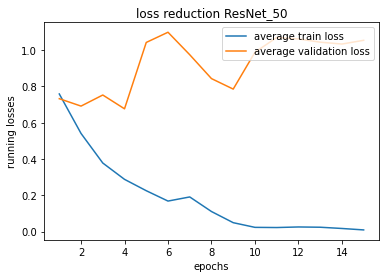

In [40]:
# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)

### **Test the Model (ResNet50)**

In [41]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_Adam_CE.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_Adam_CE.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.894624

Test Accuracy of melanoma:  68%     (79/117)
Test Accuracy of benign:  71%     (278/393)
Test Accuracy of seborrheic_keratosis:  73%     (66/90)

Test Accuracy (Overall):                                                70%     (423/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


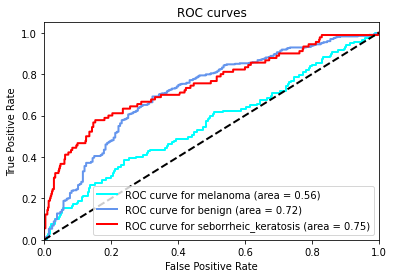

Category melanoma Score: 0.562
Category benign Score: 0.716
Category seborrheic_keratosis Score: 0.747


In [42]:
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (224,224), "results_RSN_CE_Adam.csv")
plot_scores("results_RSN_CE_Adam.csv")

## **ResNet50, SGD, Cross-Entropy**

**Specify Loss Function and Optimizer**

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_Resnet50.parameters(), lr=0.00001, weight_decay=1e-6, momentum = 0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### **Start Training (ResNet50)**

In [44]:
# Train model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_SGD_CE.pt')

Epoch [1/15] Step [100/326]	 Loss: 0.0982	 avg_Loss: 0.2114	
Epoch [1/15] Step [200/326]	 Loss: 0.2578	 avg_Loss: 0.1923	
Epoch [1/15] Step [300/326]	 Loss: 0.0749	 avg_Loss: 0.1894	
Epoch [1/15] Step [326/326]	 Loss: 0.2688	 avg_Loss: 0.1864	
Epoch [1/15]	 avg_train Loss: 0.1864			 avg_validation Loss: 0.6166	 val_accuracy: 76.67
Epoch [2/15] Step [100/326]	 Loss: 0.0329	 avg_Loss: 0.1678	
Epoch [2/15] Step [200/326]	 Loss: 0.0436	 avg_Loss: 0.1516	
Epoch [2/15] Step [300/326]	 Loss: 0.0366	 avg_Loss: 0.1485	
Epoch [2/15] Step [326/326]	 Loss: 0.0773	 avg_Loss: 0.1492	
Epoch [2/15]	 avg_train Loss: 0.1492			 avg_validation Loss: 0.6154	 val_accuracy: 76.67
Epoch [3/15] Step [100/326]	 Loss: 0.1092	 avg_Loss: 0.1431	
Epoch [3/15] Step [200/326]	 Loss: 0.2418	 avg_Loss: 0.1486	
Epoch [3/15] Step [300/326]	 Loss: 0.1274	 avg_Loss: 0.1402	
Epoch [3/15] Step [326/326]	 Loss: 0.0323	 avg_Loss: 0.1408	
Epoch [3/15]	 avg_train Loss: 0.1408			 avg_validation Loss: 0.5790	 val_accuracy: 77.33
E

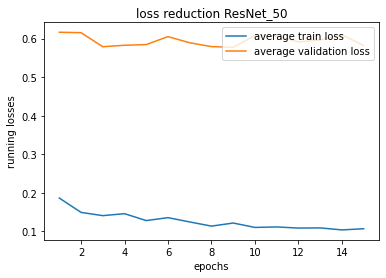

In [45]:
# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)

### **Test the Model (ResNet50)**

In [46]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_SGD_CE.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_SGD_CE.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.814989

Test Accuracy of melanoma:  60%     (70/117)
Test Accuracy of benign:  78%     (306/393)
Test Accuracy of seborrheic_keratosis:  71%     (64/90)

Test Accuracy (Overall):                                                73%     (440/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


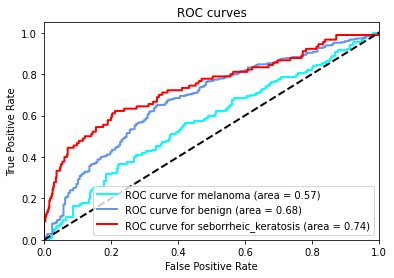

Category melanoma Score: 0.572
Category benign Score: 0.680
Category seborrheic_keratosis Score: 0.739


In [47]:
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (224,224), "results_RSN_CE_SGD.csv")
plot_scores("results_RSN_CE_SGD.csv")

# **Model Architecture (VGG-16 with Focal Loss)**

## **VGG-16, ADAM, Focal Loss**

**Specify Loss Function and Optimizer**

In [48]:
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.Adam(model_VGG.classifier.parameters(), lr=0.00001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

### **Start Training (VGG16, ADAM, Focal Loss)**

In [49]:
# train the model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'

model_VGG, train_loss, val_loss = train(n_epochs, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG_Adam_FL.pt')

Epoch [1/15] Step [100/326]	 Loss: 0.2988	 avg_Loss: 0.1520	
Epoch [1/15] Step [200/326]	 Loss: 0.2087	 avg_Loss: 0.1490	
Epoch [1/15] Step [300/326]	 Loss: 0.0903	 avg_Loss: 0.1432	
Epoch [1/15] Step [326/326]	 Loss: 0.2029	 avg_Loss: 0.1429	
Epoch [1/15]	 avg_train Loss: 0.1429			 avg_validation Loss: 0.2995	 val_accuracy: 72.67
Epoch [2/15] Step [100/326]	 Loss: 0.0981	 avg_Loss: 0.0939	
Epoch [2/15] Step [200/326]	 Loss: 0.0920	 avg_Loss: 0.0911	
Epoch [2/15] Step [300/326]	 Loss: 0.1401	 avg_Loss: 0.0950	
Epoch [2/15] Step [326/326]	 Loss: 0.1008	 avg_Loss: 0.0944	
Epoch [2/15]	 avg_train Loss: 0.0944			 avg_validation Loss: 0.2933	 val_accuracy: 73.33
Epoch [3/15] Step [100/326]	 Loss: 0.0784	 avg_Loss: 0.0658	
Epoch [3/15] Step [200/326]	 Loss: 0.0534	 avg_Loss: 0.0674	
Epoch [3/15] Step [300/326]	 Loss: 0.1003	 avg_Loss: 0.0690	
Epoch [3/15] Step [326/326]	 Loss: 0.0918	 avg_Loss: 0.0682	
Epoch [3/15]	 avg_train Loss: 0.0682			 avg_validation Loss: 0.3145	 val_accuracy: 72.00
E

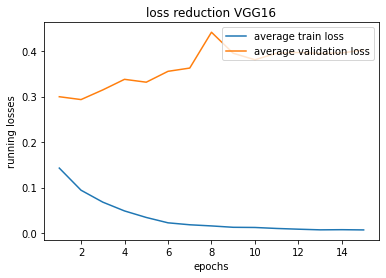

In [50]:
# Display loss reduction profile
plot_loss('VGG16', train_loss, val_loss)

### **Test the Model (VGG-16, ADAM, Focal Loss)**

In [51]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_Adam_FL.pt'))
else:
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_Adam_FL.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.373722

Test Accuracy of melanoma:  28%     (33/117)
Test Accuracy of benign:  65%     (257/393)
Test Accuracy of seborrheic_keratosis:  71%     (64/90)

Test Accuracy (Overall):                                                59%     (354/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


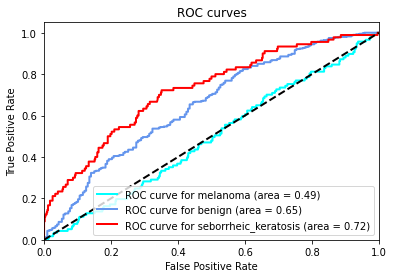

Category melanoma Score: 0.490
Category benign Score: 0.651
Category seborrheic_keratosis Score: 0.723


In [52]:
with torch.no_grad():
    test(loaders, model_VGG, criterion, use_cuda)
    get_scores(model_VGG, (224,224),"results_Vgg_FL_Adam.csv")
plot_scores("results_Vgg_FL_Adam.csv")

## **VGG-16, SGD, Focal Loss**

**Specify Loss Function and Optimizer**

In [53]:
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.SGD(model_VGG.classifier.parameters(), lr=0.00001, weight_decay=1e-6, momentum = 0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

### **Start Training (VGG16, ADAM, Cross-Entropy)**

In [54]:
# train the model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'

model_VGG, train_loss, val_loss = train(n_epochs, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG_SGD_FL.pt')

Epoch [1/15] Step [100/326]	 Loss: 0.0176	 avg_Loss: 0.0705	
Epoch [1/15] Step [200/326]	 Loss: 0.2330	 avg_Loss: 0.0716	
Epoch [1/15] Step [300/326]	 Loss: 0.0900	 avg_Loss: 0.0699	
Epoch [1/15] Step [326/326]	 Loss: 0.0327	 avg_Loss: 0.0687	
Epoch [1/15]	 avg_train Loss: 0.0687			 avg_validation Loss: 0.2928	 val_accuracy: 72.67
Epoch [2/15] Step [100/326]	 Loss: 0.0610	 avg_Loss: 0.0631	
Epoch [2/15] Step [200/326]	 Loss: 0.0361	 avg_Loss: 0.0699	
Epoch [2/15] Step [300/326]	 Loss: 0.0708	 avg_Loss: 0.0687	
Epoch [2/15] Step [326/326]	 Loss: 0.1005	 avg_Loss: 0.0690	
Epoch [2/15]	 avg_train Loss: 0.0690			 avg_validation Loss: 0.2927	 val_accuracy: 72.00
Epoch [3/15] Step [100/326]	 Loss: 0.0497	 avg_Loss: 0.0690	
Epoch [3/15] Step [200/326]	 Loss: 0.0357	 avg_Loss: 0.0685	
Epoch [3/15] Step [300/326]	 Loss: 0.1139	 avg_Loss: 0.0676	
Epoch [3/15] Step [326/326]	 Loss: 0.0398	 avg_Loss: 0.0668	
Epoch [3/15]	 avg_train Loss: 0.0668			 avg_validation Loss: 0.2931	 val_accuracy: 73.33
E

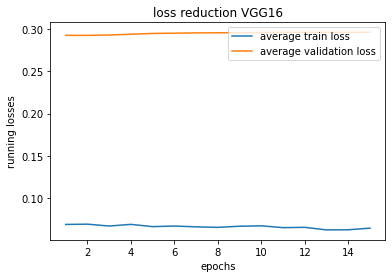

In [55]:
# Display loss reduction profile
plot_loss('VGG16', train_loss, val_loss)

### **Test the Model (VGG-16, SGD, Focal Loss)**

In [56]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_SGD_FL.pt'))
else:
    model_VGG.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_VGG_SGD_FL.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.371378

Test Accuracy of melanoma:  38%     (45/117)
Test Accuracy of benign:  65%     (256/393)
Test Accuracy of seborrheic_keratosis:  69%     (62/90)

Test Accuracy (Overall):                                                60%     (363/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


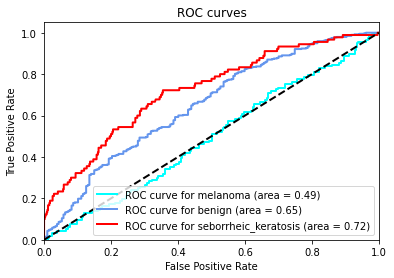

Category melanoma Score: 0.492
Category benign Score: 0.651
Category seborrheic_keratosis Score: 0.722


In [57]:
with torch.no_grad():
    test(loaders, model_VGG, criterion, use_cuda)
    get_scores(model_VGG, (224,224),"results_Vgg_FL_SGD.csv")
plot_scores("results_Vgg_FL_SGD.csv")

# **Model Architecture (ResNet50 with Focal Loss)**

## **ResNet50, ADAM, Focal Loss**

**Specify Loss Function and Optimizer**

In [58]:
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.Adam(model_Resnet50.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### **Start Training (ResNet50)**

Epoch [1/15] Step [100/326]	 Loss: 0.2345	 avg_Loss: 0.0776	
Epoch [1/15] Step [200/326]	 Loss: 0.1728	 avg_Loss: 0.1024	
Epoch [1/15] Step [300/326]	 Loss: 0.0514	 avg_Loss: 0.0916	
Epoch [1/15] Step [326/326]	 Loss: 0.0091	 avg_Loss: 0.0904	
Epoch [1/15]	 avg_train Loss: 0.0904			 avg_validation Loss: 0.2287	 val_accuracy: 80.00
Epoch [2/15] Step [100/326]	 Loss: 0.0282	 avg_Loss: 0.0538	
Epoch [2/15] Step [200/326]	 Loss: 0.0155	 avg_Loss: 0.0491	
Epoch [2/15] Step [300/326]	 Loss: 0.0357	 avg_Loss: 0.0508	
Epoch [2/15] Step [326/326]	 Loss: 0.0592	 avg_Loss: 0.0516	
Epoch [2/15]	 avg_train Loss: 0.0516			 avg_validation Loss: 0.4545	 val_accuracy: 75.33
Epoch [3/15] Step [100/326]	 Loss: 0.0187	 avg_Loss: 0.0488	
Epoch [3/15] Step [200/326]	 Loss: 0.0197	 avg_Loss: 0.0657	
Epoch [3/15] Step [300/326]	 Loss: 0.0363	 avg_Loss: 0.0690	
Epoch [3/15] Step [326/326]	 Loss: 0.2907	 avg_Loss: 0.0688	
Epoch [3/15]	 avg_train Loss: 0.0688			 avg_validation Loss: 0.3384	 val_accuracy: 74.67
E

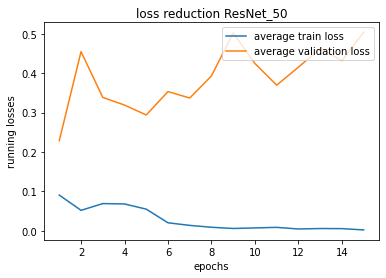

In [59]:
# Train model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_Adam_FL.pt')

# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)

### **Test the Model (ResNet50)**

In [60]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_Adam_FL.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_Adam_FL.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.384246

Test Accuracy of melanoma:  41%     (48/117)
Test Accuracy of benign:  80%     (315/393)
Test Accuracy of seborrheic_keratosis:  73%     (66/90)

Test Accuracy (Overall):                                                72%     (429/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


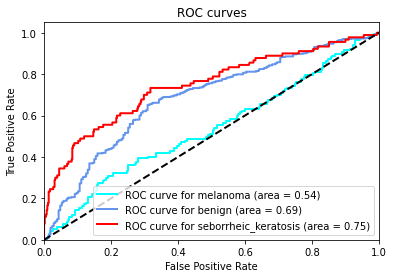

Category melanoma Score: 0.535
Category benign Score: 0.686
Category seborrheic_keratosis Score: 0.746


In [61]:
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (224,224), "results_RSN_FL_Adam.csv")
plot_scores("results_RSN_FL_Adam.csv")

## **ResNet50, SGD, Focal Loss**

**Specify Loss Function and Optimizer**

In [62]:
criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)
optimizer = optim.SGD(model_Resnet50.parameters(), lr=0.00001, weight_decay=1e-6, momentum = 0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### **Start Training (ResNet50)**

In [63]:
# Train model
n_epochs = 15
print_every = 100
save_path = '/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models'
model_Resnet50, train_loss, val_loss = train(n_epochs, loaders, model_Resnet50, optimizer, criterion, use_cuda,
                                           'model_Resnet50_SGD_FL.pt')

Epoch [1/15] Step [100/326]	 Loss: 0.0112	 avg_Loss: 0.0675	
Epoch [1/15] Step [200/326]	 Loss: 0.0102	 avg_Loss: 0.0618	
Epoch [1/15] Step [300/326]	 Loss: 0.0929	 avg_Loss: 0.0576	
Epoch [1/15] Step [326/326]	 Loss: 0.0468	 avg_Loss: 0.0568	
Epoch [1/15]	 avg_train Loss: 0.0568			 avg_validation Loss: 0.2029	 val_accuracy: 81.33
Epoch [2/15] Step [100/326]	 Loss: 0.0799	 avg_Loss: 0.0501	
Epoch [2/15] Step [200/326]	 Loss: 0.0252	 avg_Loss: 0.0493	
Epoch [2/15] Step [300/326]	 Loss: 0.0619	 avg_Loss: 0.0455	
Epoch [2/15] Step [326/326]	 Loss: 0.0132	 avg_Loss: 0.0465	
Epoch [2/15]	 avg_train Loss: 0.0465			 avg_validation Loss: 0.1970	 val_accuracy: 80.67
Epoch [3/15] Step [100/326]	 Loss: 0.0144	 avg_Loss: 0.0473	
Epoch [3/15] Step [200/326]	 Loss: 0.0203	 avg_Loss: 0.0451	
Epoch [3/15] Step [300/326]	 Loss: 0.0034	 avg_Loss: 0.0426	
Epoch [3/15] Step [326/326]	 Loss: 0.0307	 avg_Loss: 0.0438	
Epoch [3/15]	 avg_train Loss: 0.0438			 avg_validation Loss: 0.1837	 val_accuracy: 81.33
E

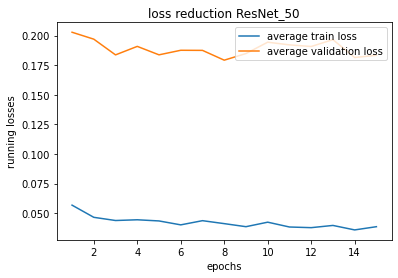

In [64]:
# Display loss reduction profile
plot_loss('ResNet_50', train_loss, val_loss)

### **Test the Model (ResNet50)**

In [65]:
# load the model that got the best validation accuracy (uncomment the line below)
if torch.cuda.is_available():
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_SGD_FL.pt'))
else:
    model_Resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ISIC 2017/models/model_Resnet50_SGD_FL.pt', map_location=torch.device('cpu')))

  0%|          | 0/60 [00:00<?, ?it/s]

Test Loss: 0.342943

Test Accuracy of melanoma:  56%     (65/117)
Test Accuracy of benign:  74%     (290/393)
Test Accuracy of seborrheic_keratosis:  74%     (67/90)

Test Accuracy (Overall):                                                70%     (422/600)

getting predictions on all test images:


  0%|          | 0/600 [00:00<?, ?it/s]

writing score csv file


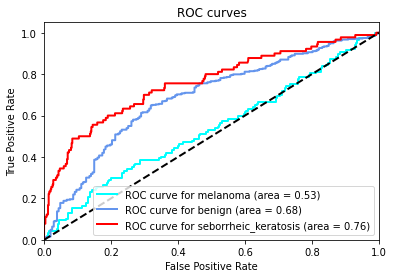

Category melanoma Score: 0.534
Category benign Score: 0.685
Category seborrheic_keratosis Score: 0.757


In [66]:
with torch.no_grad():
    test(loaders, model_Resnet50, criterion, use_cuda)
    get_scores(model_Resnet50, (224,224), "results_RSN_FL_SGD.csv")
plot_scores("results_RSN_FL_SGD.csv")